In [1]:
from __future__ import division, print_function, absolute_import
from scipy.io import loadmat 
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from hyperdash import monitor_cell
from hyperdash import Experiment

In [2]:
import sys
def printf(format, *args):
    sys.stdout.write(format % args)

In [3]:
def data_split (tdata):
    #tdata = tdata.transpose()
    td1, td2, td3, td4, td5, td6, td7, td8, td9, td10 = np.array_split(tdata, 10)
    
    tdata = np.concatenate((td1, td2, td3, td4, td5, td6, td7, td8), axis = 0)
    test_data = np.concatenate((td9, td10), axis = 0)
    
    #tdata = tdata.transpose()
    #test_data = test_data.transpose()
    
    
    return tdata, test_data

In [4]:
def data_loader(trainDir):
    ###############################################################################
    # This section loads the training dataset
    ###############################################################################
    trainDir            = trainDir
    TrainingDataFiles   = []

    for r, d, f in os.walk(trainDir):
        for file in f:
            TrainingDataFiles.append(os.path.join(r,file))

    # load files and put them into a matrix
    tdata = loadmat(TrainingDataFiles[0])['X']          
    for i in range(1,len(TrainingDataFiles)):            
        td      = loadmat(TrainingDataFiles[i])['X']
        tdata   = np.concatenate((tdata,td), axis = 1)

    # put observations in rows
    tdata       = tdata.transpose()
    print(tdata.shape)
    ###############################################################################
    # Splits Data into training (80%) and testing (20%)
    ###############################################################################
    #tdata, test_data = data_split(tdata)
    return tdata

In [8]:
def sparseLinAutoEncoder(wscale, learn_rate, num_steps, beta, counter, tdata):   
    # simulation meta-parameters
    wscale          = wscale;  # scale of the small random weights for model initialization
    beta            = beta;  # hyper-parameter which determines penality size
    learn_rate      = learn_rate;
    batch_size      = 5000;
    nBat            = 50000;
    num_steps       = num_steps;
    display_step    = 100
    examples_to_show    = 5

  
    exp = Experiment("SparceLinAutoEncoderRELU8")
    
    ###############################################################################
    # Splits Data into training (80%) and testing (20%)
    ###############################################################################
    tdata, test_data = data_split(tdata)
    
    
    ###############################################################################
    # Define neural network graph
    ###############################################################################
    num_input   = tdata.shape[1]
    num_train   = tdata.shape[0]
    pixel_size  = int(np.sqrt(float(num_input)))

    # compressive auto-encoder reduces dimensionality
    # num_hidden  = round(num_input/2)
    # sparse auto-encoder keeps dimensionality same or larger
    num_hidden = num_input 

    # this placeholder will hold the training batch
    X = tf.placeholder("float", [None, num_input])


    ## These are a hash map to variables that are used as the weights and biases in 
    ## the neural network layers. Note that the layers have differnet number of filters
    ## and that the input passes through these layers and take the shape of the layers.
    ## It helps to think of a network as a pipline.
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden],mean=0.0, stddev=wscale)),
        'decoder_h1': tf.Variable(tf.random_normal([num_hidden, num_input],mean=0.0, stddev=wscale))
    }

    ## Building the encoder This layer has two layers that are concatinated into a 
    ## a single layer. This layer should reduce the input vector to a matrix of diffrent
    ## deminsions.
    def encoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.relu(tf.matmul(x, weights['encoder_h1']))
        return layer_1

    ## Building the decoder This is simular to the process that is happening in the
    ## encoder code but this layer further reduces the demensionality.
    def decoder(x):
        # Decoder Hidden layer with sigmoid activation #1
        layer_1 = tf.matmul(x, weights['decoder_h1'])
        #layer_1 =  tf.matmul(x, tf.transpose(weights['encoder_h1']))
        return layer_1

    ## Construct model by forming the encoded input and the decoded encoder
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    ## Prediction 
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    ## Define loss and optimizer, minimize the squared error


    errorterm   = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    sparseterm  = tf.reduce_mean(tf.abs(encoder_op))

    loss        = errorterm + beta*sparseterm 

    ## Note this is not the only optimizer and infact we should look into which one we
    ## should use for our project!!!!! ADAMOptimizer is a well known and utilize option. 
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    #
    ## Initialize the variables (i.e. assign their default value)
    init    = tf.global_variables_initializer()
    saver   = tf.train.Saver()

    ###############################################################################
    # Start Training
    ###############################################################################

    # Start a new TF session
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training
        for i in range(1, num_steps+1):
            # Prepare Data
            temp    = np.random.permutation(num_train)
            bat_ind = temp[0:batch_size]
            batch_x = tdata[bat_ind,:]


            # Run optimization op (backprop) and cost op (to get loss value)
            _, l , e, s = sess.run([optimizer, loss, errorterm, sparseterm], feed_dict={X: batch_x})
            # Display logs per step
            if i % display_step == 0 or i == 1:
                print('Step %i: Minibatch Loss: %f Error: %f Sparse: %f' % (i, l, e, s))
                exp.metric("Loss ", e);
                exp.metric("Sparse ", s);

        final_W = weights['encoder_h1'].eval()

        # Testing
        # Encode and decode images from test set and visualize their reconstruction.
        n = examples_to_show
        k1 = 1
        k2 = 1
        canvas_orig = np.empty((pixel_size * n, pixel_size * n))
        canvas_recon = np.empty((pixel_size * n, pixel_size * n))
        for i in range(n):

            g = sess.run(decoder_op, feed_dict={X: batch_x})
            # Display original images
            for j in range(n):
                # Draw the original digits
                canvas_orig[i * pixel_size:(i + 1) * pixel_size, j * pixel_size:(j + 1) * pixel_size] = \
                    batch_x[k1].reshape([pixel_size, pixel_size])
                k1 = k1 + 1
            # Display reconstructed images
            for j in range(n):
                # Draw the reconstructed digits
                canvas_recon[i * pixel_size:(i + 1) * pixel_size, j * pixel_size:(j + 1) * pixel_size] = \
                    g[k2].reshape([pixel_size, pixel_size])
                k2 = k2 + 1

        #print("Original Images")
        #plt.figure(figsize=(n, n))
        #plt.imshow(canvas_orig, origin="upper", cmap="gray")
        #plt.show()

        #print("Reconstructed Images")
        #plt.figure(figsize=(n, n))
        #plt.imshow(canvas_recon, origin="upper", cmap="gray")
        #plt.show()
        #print(canvas_orig)
        
        
        save_path = saver.save(sess,"./epochCkpt/sparseLinTrainMiniBatFinal" + str(counter) + ".ckpt")
        

    
    Z = final_W
    nHid            = Z.shape[1]            # get the number of hidden units
    imSz            = int(np.sqrt(Z.shape[0]))   # size of each image patch
    plotGap2        = 1                     # half the gap to leave between each image patch
    imSzPlot        = int(imSz + 2*plotGap2)    

    layoutSqDim     = int(np.ceil(np.sqrt(nHid)))  # find dimensions for layout
    arrayImage      = np.zeros((layoutSqDim*imSzPlot,layoutSqDim*imSzPlot))

    k = 0
    for i in range(layoutSqDim):
        for j in range(layoutSqDim):
            if k < nHid:    
                littleImPlot = np.zeros((imSzPlot,imSzPlot))
                littleImPlot[(plotGap2):(imSzPlot-plotGap2),(plotGap2):(imSzPlot-plotGap2)] = np.reshape(Z[:,k],(imSz,imSz)) 
                arrayImage[ (i*imSzPlot ):((i+1)*imSzPlot) , (j*imSzPlot ):((j+1)*imSzPlot) ] = littleImPlot;
                k = k + 1

    output = [l, e, s, canvas_orig, canvas_recon, arrayImage]
    plt.imshow(arrayImage,  cmap='Greys')
    #plt.show()
    
    sess.close()
    exp.end()
    return output
    

(80000, 64)
| Loss :   0.002087 |
| Sparse :   0.042811 |
Step 1400: Minibatch Loss: 0.002515 Error: 0.002087 Sparse: 0.042811
Step 1: Minibatch Loss: 0.020371 Error: 0.018462 Sparse: 0.038184
| Loss :   0.018462 |
| Sparse :   0.038184 |
| Loss :   0.002082 |
| Sparse :   0.041819 |
Step 1500: Minibatch Loss: 0.002501 Error: 0.002082 Sparse: 0.041819
Step 100: Minibatch Loss: 0.003498 Error: 0.002496 Sparse: 0.020044
| Loss :   0.002496 |
| Sparse :   0.020044 |
| Loss :   0.002063 |
| Sparse :   0.040650 |
Step 1600: Minibatch Loss: 0.002469 Error: 0.002063 Sparse: 0.040650
Step 200: Minibatch Loss: 0.003365 Error: 0.002538 Sparse: 0.016546
| Loss :   0.002538 |
| Sparse :   0.016546 |
| Loss :   0.001987 |
| Sparse :   0.039584 |
Step 1700: Minibatch Loss: 0.002383 Error: 0.001987 Sparse: 0.039584
Step 300: Minibatch Loss: 0.003219 Error: 0.002490 Sparse: 0.014573
| Loss :   0.002490 |
| Sparse :   0.014573 |
| Loss :   0.002028 |
| Sparse :   0.038673 |
Step 1800: Minibatch Loss: 0

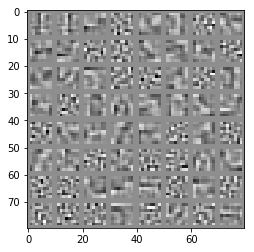

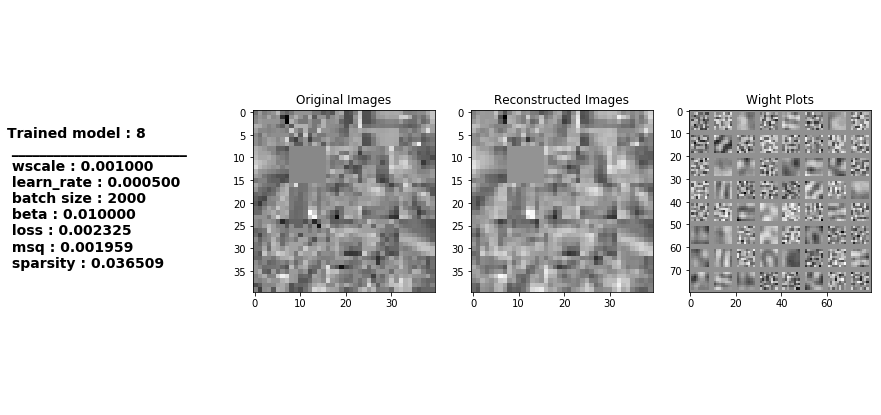

Step 400: Minibatch Loss: 0.009863 Error: 0.008469 Sparse: 0.013946
| Loss :   0.008469 |
| Sparse :   0.013946 |
Step 500: Minibatch Loss: 0.008853 Error: 0.007343 Sparse: 0.015094
| Loss :   0.007343 |
| Sparse :   0.015094 |
Step 600: Minibatch Loss: 0.008206 Error: 0.006677 Sparse: 0.015287
| Loss :   0.006677 |
| Sparse :   0.015287 |
Step 700: Minibatch Loss: 0.007889 Error: 0.006397 Sparse: 0.014921
| Loss :   0.006397 |
| Sparse :   0.014921 |
Step 800: Minibatch Loss: 0.007520 Error: 0.006053 Sparse: 0.014667
| Loss :   0.006053 |
| Sparse :   0.014667 |
Step 900: Minibatch Loss: 0.007145 Error: 0.005705 Sparse: 0.014401
| Loss :   0.005705 |
| Sparse :   0.014401 |
Step 1000: Minibatch Loss: 0.007008 Error: 0.005630 Sparse: 0.013778
| Loss :   0.005630 |
| Sparse :   0.013778 |
Step 1100: Minibatch Loss: 0.006882 Error: 0.005557 Sparse: 0.013251
| Loss :   0.005557 |
| Sparse :   0.013251 |
Step 1200: Minibatch Loss: 0.006657 Error: 0.005333 Sparse: 0.013237
| Loss :   0.0053

In [10]:
tdata = data_loader('RawData/TrainingData8')
out = sparseLinAutoEncoder(.1, .05, 1000, .05 ,555, tdata)

(80000, 64)
Step 1: Minibatch Loss: 0.015422 Error: 0.015422 Sparse: 0.000393
| Loss :   0.015422 |
| Sparse :   0.000393 |
Step 100: Minibatch Loss: 0.010024 Error: 0.010020 Sparse: 0.039883
| Loss :   0.010020 |
| Sparse :   0.039883 |
Step 200: Minibatch Loss: 0.006868 Error: 0.006863 Sparse: 0.050999
| Loss :   0.006863 |
| Sparse :   0.050999 |
Step 300: Minibatch Loss: 0.005483 Error: 0.005477 Sparse: 0.055347
| Loss :   0.005477 |
| Sparse :   0.055347 |
Step 400: Minibatch Loss: 0.004424 Error: 0.004418 Sparse: 0.058617
| Loss :   0.004418 |
| Sparse :   0.058617 |
Step 500: Minibatch Loss: 0.003757 Error: 0.003751 Sparse: 0.060069
| Loss :   0.003751 |
| Sparse :   0.060069 |
Step 600: Minibatch Loss: 0.003232 Error: 0.003226 Sparse: 0.061466
| Loss :   0.003226 |
| Sparse :   0.061466 |
Step 700: Minibatch Loss: 0.002861 Error: 0.002855 Sparse: 0.062204
| Loss :   0.002855 |
| Sparse :   0.062204 |
Step 800: Minibatch Loss: 0.002651 Error: 0.002644 Sparse: 0.062147
| Loss :  

| Sparse :   0.062538 |
Step 800: Minibatch Loss: 0.002751 Error: 0.002745 Sparse: 0.062701
| Loss :   0.002745 |
| Sparse :   0.062701 |
Step 900: Minibatch Loss: 0.002544 Error: 0.002537 Sparse: 0.062709
| Loss :   0.002537 |
| Sparse :   0.062709 |
Step 1000: Minibatch Loss: 0.002454 Error: 0.002448 Sparse: 0.062627
| Loss :   0.002448 |
| Sparse :   0.062627 |
Step 1100: Minibatch Loss: 0.002353 Error: 0.002347 Sparse: 0.062105
| Loss :   0.002347 |
| Sparse :   0.062105 |
Step 1200: Minibatch Loss: 0.002314 Error: 0.002308 Sparse: 0.061366
| Loss :   0.002308 |
| Sparse :   0.061366 |
Step 1300: Minibatch Loss: 0.002222 Error: 0.002215 Sparse: 0.060919
| Loss :   0.002215 |
| Sparse :   0.060919 |
Step 1400: Minibatch Loss: 0.002217 Error: 0.002211 Sparse: 0.060539
| Loss :   0.002211 |
| Sparse :   0.060539 |
Step 1500: Minibatch Loss: 0.002139 Error: 0.002133 Sparse: 0.060158
| Loss :   0.002133 |
| Sparse :   0.060158 |
Step 1600: Minibatch Loss: 0.002090 Error: 0.002084 Sparse

SystemExit: 130

C:\Users\cjhamilton4176\AppData\Local\conda\conda\envs\DeepLearner\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


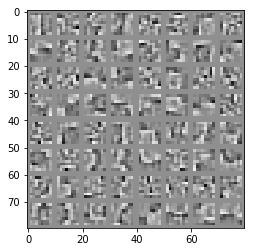

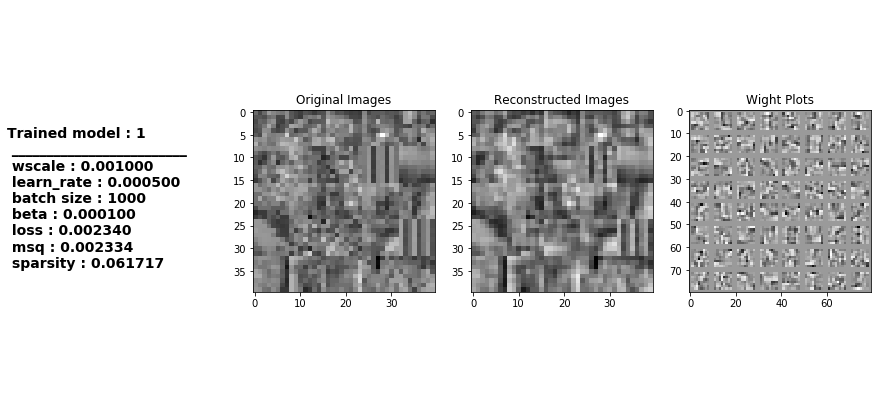

Step 800: Minibatch Loss: 0.003084 Error: 0.002593 Sparse: 0.049084
| Loss :   0.002593 |
| Sparse :   0.049084 |


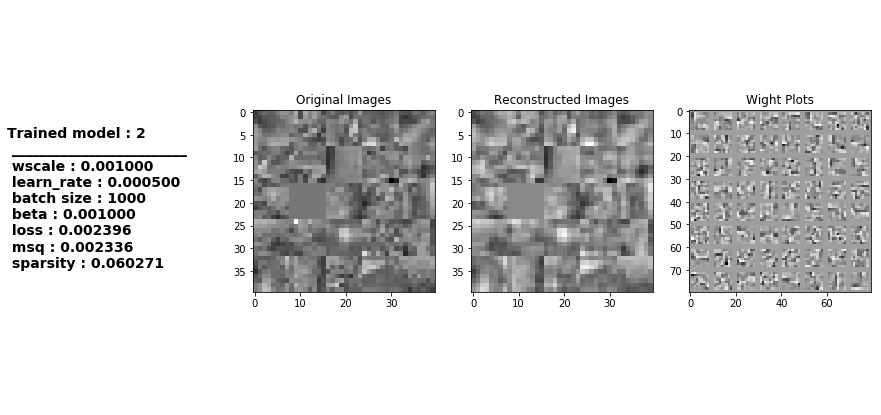

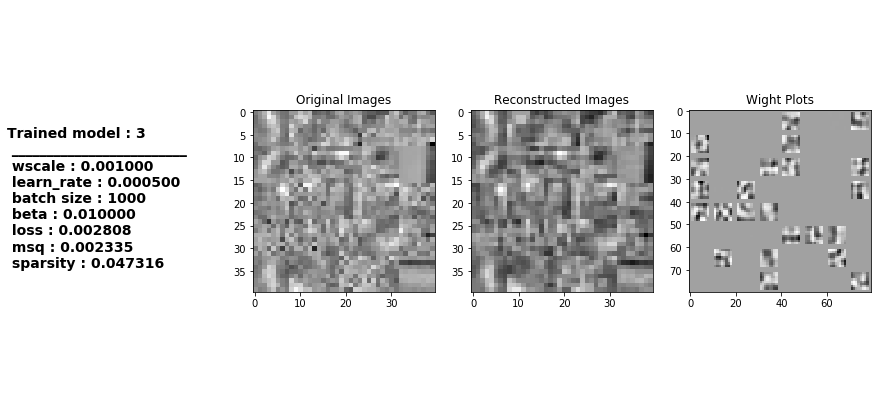

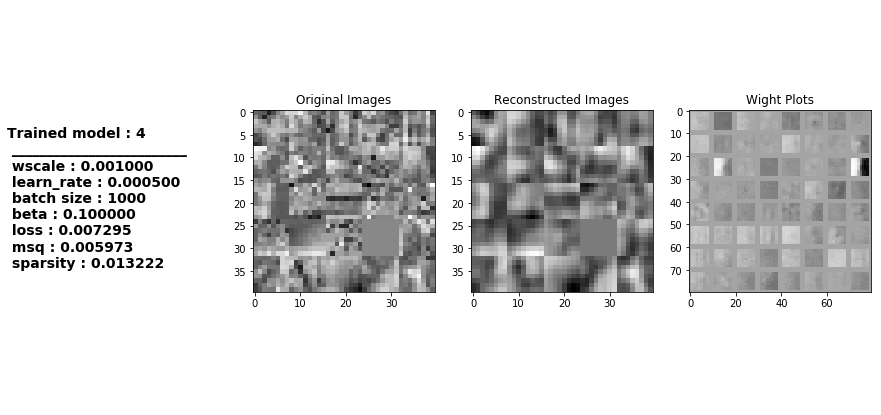

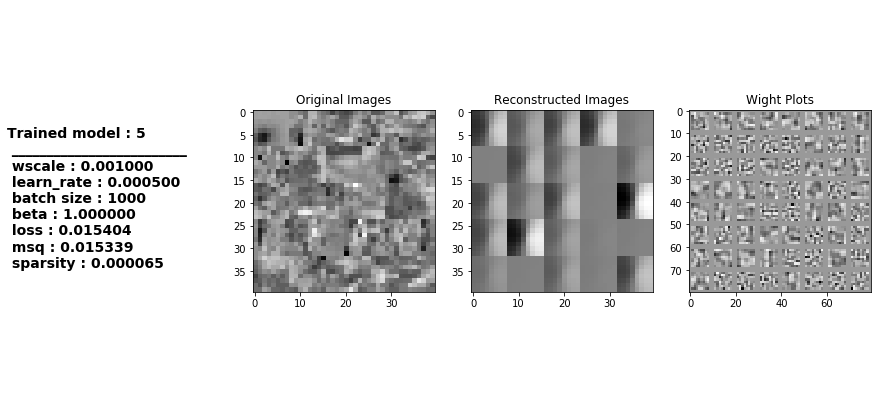

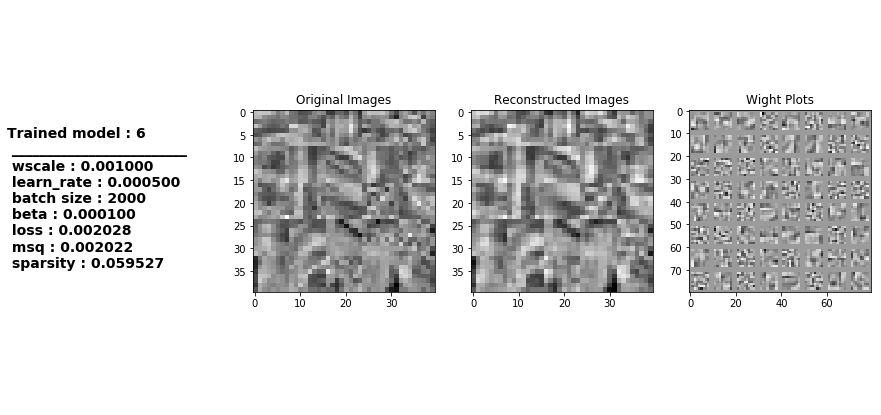

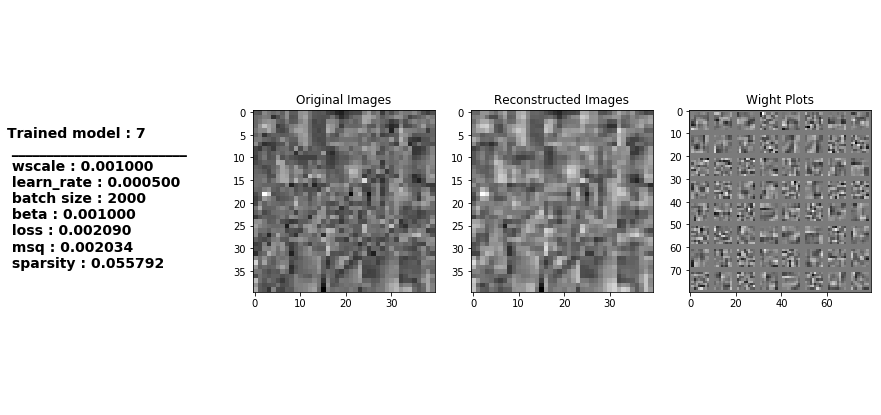

Step 900: Minibatch Loss: 0.002907 Error: 0.002424 Sparse: 0.048261
| Loss :   0.002424 |
| Sparse :   0.048261 |
Step 1000: Minibatch Loss: 0.002789 Error: 0.002316 Sparse: 0.047207
| Loss :   0.002316 |
| Sparse :   0.047207 |
Step 1100: Minibatch Loss: 0.002731 Error: 0.002268 Sparse: 0.046325
| Loss :   0.002268 |
| Sparse :   0.046325 |
Step 1200: Minibatch Loss: 0.002606 Error: 0.002155 Sparse: 0.045066
| Loss :   0.002155 |
| Sparse :   0.045066 |
Step 1300: Minibatch Loss: 0.002548 Error: 0.002109 Sparse: 0.043865
| Loss :   0.002109 |
| Sparse :   0.043865 |


In [9]:
%%monitor_cell "Metric Eval"
counter = 0
tdata = data_loader('RawData/TrainingData8')
with PdfPages('Results/ModelPlotsRELU8_2.pdf') as pdf:
    for wscale in range(-3,-1,1):
        wscale = 1*(10**wscale)
        for learn_rate in range(-4,1,1):
            learn_rate = 5*(10**learn_rate)
            for nIterBat in range(1000,6000,1000):
                for beta in range(-4,1,1):
                    
                    beta = 1*(10**beta)
                    counter = counter + 1
                    out = sparseLinAutoEncoder(wscale, learn_rate, nIterBat, beta, counter, tdata)
                    fig = plt.figure(figsize=(15, 7))
                    txt = "Trained model : %d \n _________________________\n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(counter, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
                    fig.suptitle(txt,x = 0.1, y= .65, fontsize=14, fontweight='bold', ha = 'left')
                    
                    fig.add_subplot(1,4,1).axis('off')

                    fig.add_subplot(1, 4 , 2)
                    plt.title('Original Images')
                    plt.imshow(out[3], origin="upper", cmap="gray")
                    fig.add_subplot(1,4,3)
                    plt.title('Reconstructed Images')
                    plt.imshow(out[4], origin="upper", cmap="gray")
                    fig.add_subplot(1,4,4)
                    plt.title('Wight Plots')
                    plt.imshow(out[5], cmap="gray")
                    pdf.savefig(fig)

In [ ]:
import PyPDF2

wscale          = .1;  # scale of the small random weights for model initialization
beta            = .05;  # hyper-parameter which determines penality size
learn_rate      = .05;
nIterBat      = 1000;
nBat            = 5000;
num_steps       = 5;

with PdfPages('ModelPlots16.pdf') as pdf:
    

    fig = plt.figure(figsize=(15, 7))
    #fig.subplots_adjust(top=2.5)
    txt = "Trained model : %d \n _________________________\n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(1, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
    fig.suptitle(txt,x = 0.1, y= .65, fontsize=14, fontweight='bold', ha = 'left')
    #pdf.savefig(fig)
    fig.add_subplot(1,4,1).axis('off')
    
    fig.add_subplot(1, 4 , 2)
    plt.title('Original Images')
    plt.imshow(out[3], origin="upper", cmap="gray")
    fig.add_subplot(1,4,3)
    plt.title('Reconstructed Images')
    plt.imshow(out[4], origin="upper", cmap="gray")
    fig.add_subplot(1,4,4)
    plt.title('Wight Plots')
    plt.imshow(out[5], cmap="gray")
    
    
    #fig.text(0.05,1.35,txt, transform=fig.transFigure, size=20)
#     txt = "Trained model : %d \n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(1, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
#     ax.figtext(0.05,1.1,txt, transform=fig.transFigure, size=20)

    #plt.close()
    pdf.savefig(fig)
    plt.show()
    plt.close()

In [ ]:
pdf